In [1]:
%load_ext autoreload
%autoreload 2

## Driving GPT
### Original Idea from [Geval et al](https://arxiv.org/abs/2203.14680)

In [2]:
import torch
import json
from utils import nethook
from utils import model_utils
from tqdm import tqdm

### Load Model

In [4]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [43]:
prompt = ["My wife is working as a"]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 50,
    debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

' nurse'[15849] -- 6.068979740142822 [' nurse'(6.069) ' teacher'(5.602) ' secretary'(1.812) ' n'(1.345) ' home'(1.342) ]
' in'[287] -- 33.661949157714844 [' in'(33.662) ' and'(14.851) ' at'(12.634) ','(7.291) '.'(5.623) ]
' a'[257] -- 39.44446563720703 [' a'(39.444) ' the'(16.802) ' an'(4.576) ' one'(1.255) ' India'(0.973) ]
' hospital'[4436] -- 22.863826751708984 [' hospital'(22.864) ' private'(6.094) ' local'(4.439) ' small'(3.875) ' nursing'(2.57) ]
'.'[13] -- 22.47379493713379 ['.'(22.474) ' in'(20.212) ' and'(19.487) ','(12.974) ' where'(1.826) ]
' She'[1375] -- 28.857473373413086 [' She'(28.857) ' I'(11.856) ' We'(7.507) ' It'(4.27) ' The'(4.195) ]
' is'[318] -- 17.278675079345703 [' is'(17.279) ' has'(16.177) ' works'(7.077) ''s'(4.559) '�'(3.953) ]
' a'[257] -- 13.215200424194336 [' a'(13.215) ' working'(4.274) ' on'(3.667) ' very'(3.421) ' in'(3.239) ]
' very'[845] -- 10.159626007080078 [' very'(10.16) ' nurse'(6.243) ' registered'(3.813) ' single'(3.34) ' good'(3.317) ]
' goo

In [8]:
ret_dict['answer']

[{'top_token': ' nurse',
  'candidates': [{'token': ' nurse', 'token_id': 15849, 'p': 0.0607},
   {'token': ' teacher', 'token_id': 4701, 'p': 0.056},
   {'token': ' secretary', 'token_id': 7705, 'p': 0.0181},
   {'token': ' n', 'token_id': 299, 'p': 0.0135},
   {'token': ' home', 'token_id': 1363, 'p': 0.0134}]}]

In [14]:
# for name, value in model.named_parameters():
#     print(name, " :: ", value.shape)

### Find and store the vocabs promoted by each of the MLPs

In [15]:
unembedding = nethook.get_module(model, "lm_head")

In [73]:
fc_out_format = "transformer.h.{}.mlp.fc_out.weight"
def get_tokens_promoted_by_fc_proj_at_layer(model, layer_no, k = 100):
    param = nethook.get_parameter(model, fc_out_format.format(layer_no))
    ret = {}
    for col in tqdm(range(param.shape[1])):
        logits = unembedding(param[:, col])
        softmax = torch.nn.functional.softmax(logits, dim = 0)
        top_k = torch.topk(softmax, k = k)
        
        ret[f'column_{col}'] = {
            tokenizer.decode(idx): {"p": softmax[idx].item(), "idx": idx.item()}
            for idx in top_k.indices
        }
        # break
    return ret

# get_tokens_promoted_by_fc_proj_at_layer(model, 25)

In [74]:
for layer in range(model.config.n_layer):
    print(f"saving vocabs promoted by layer {layer}")
    promoted_vocabs = get_tokens_promoted_by_fc_proj_at_layer(model, layer, k = 500)
    with open(f"fc_out_vocab/layer_{layer}.json", 'w') as f:
        json.dump(promoted_vocabs, f)

saving vocabs promoted by layer 0


100%|██████████| 16384/16384 [05:23<00:00, 50.63it/s]


saving vocabs promoted by layer 1


100%|██████████| 16384/16384 [05:23<00:00, 50.66it/s]


saving vocabs promoted by layer 2


100%|██████████| 16384/16384 [05:25<00:00, 50.30it/s]


saving vocabs promoted by layer 3


100%|██████████| 16384/16384 [05:22<00:00, 50.79it/s]


saving vocabs promoted by layer 4


100%|██████████| 16384/16384 [05:23<00:00, 50.72it/s]


saving vocabs promoted by layer 5


100%|██████████| 16384/16384 [05:23<00:00, 50.64it/s]


saving vocabs promoted by layer 6


100%|██████████| 16384/16384 [05:24<00:00, 50.46it/s]


saving vocabs promoted by layer 7


100%|██████████| 16384/16384 [05:25<00:00, 50.35it/s]


saving vocabs promoted by layer 8


100%|██████████| 16384/16384 [05:24<00:00, 50.44it/s]


saving vocabs promoted by layer 9


100%|██████████| 16384/16384 [05:23<00:00, 50.65it/s]


saving vocabs promoted by layer 10


100%|██████████| 16384/16384 [05:23<00:00, 50.62it/s]


saving vocabs promoted by layer 11


100%|██████████| 16384/16384 [05:23<00:00, 50.69it/s]


saving vocabs promoted by layer 12


100%|██████████| 16384/16384 [05:22<00:00, 50.81it/s]


saving vocabs promoted by layer 13


100%|██████████| 16384/16384 [05:15<00:00, 51.90it/s]


saving vocabs promoted by layer 14


100%|██████████| 16384/16384 [05:18<00:00, 51.48it/s]


saving vocabs promoted by layer 15


100%|██████████| 16384/16384 [05:20<00:00, 51.18it/s]


saving vocabs promoted by layer 16


100%|██████████| 16384/16384 [05:24<00:00, 50.45it/s]


saving vocabs promoted by layer 17


100%|██████████| 16384/16384 [05:23<00:00, 50.66it/s]


saving vocabs promoted by layer 18


100%|██████████| 16384/16384 [05:18<00:00, 51.42it/s]


saving vocabs promoted by layer 19


100%|██████████| 16384/16384 [05:21<00:00, 50.97it/s]


saving vocabs promoted by layer 20


100%|██████████| 16384/16384 [05:22<00:00, 50.74it/s]


saving vocabs promoted by layer 21


100%|██████████| 16384/16384 [05:22<00:00, 50.86it/s]


saving vocabs promoted by layer 22


100%|██████████| 16384/16384 [05:25<00:00, 50.33it/s]


saving vocabs promoted by layer 23


100%|██████████| 16384/16384 [05:25<00:00, 50.31it/s]


saving vocabs promoted by layer 24


100%|██████████| 16384/16384 [05:20<00:00, 51.19it/s]


saving vocabs promoted by layer 25


100%|██████████| 16384/16384 [05:23<00:00, 50.58it/s]


saving vocabs promoted by layer 26


100%|██████████| 16384/16384 [05:21<00:00, 50.91it/s]


saving vocabs promoted by layer 27


100%|██████████| 16384/16384 [05:21<00:00, 50.90it/s]


## Investigate

In [46]:
layer = 17
column = 157

In [5]:
with open(f"Saved_weights/fc_out_vocab/layer_{layer}.json") as f:
    res = json.load(f)

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [36]:
dist = [proba['p'] for key, proba in res[f'column_{column}'].items()]


In [37]:
import numpy as np

np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

(0.0, 4e-05)

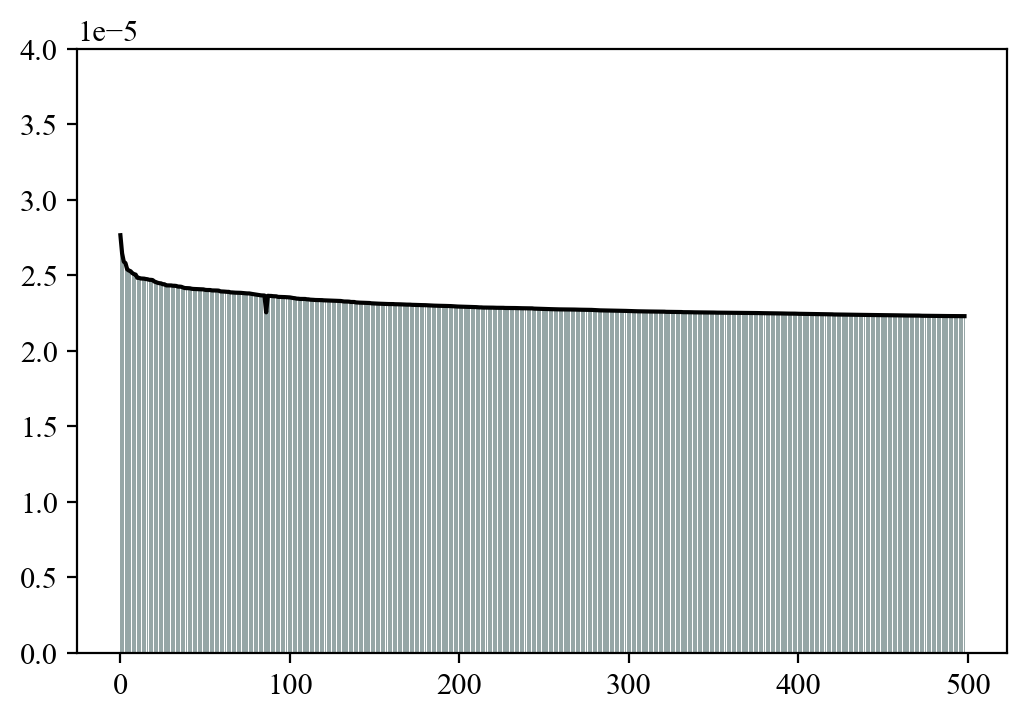

In [38]:
plt.bar(np.arange(len(dist)),  dist, alpha = 0.5, color = 'darkslategray')
plt.plot(np.arange(len(dist)),  dist, alpha = 1, color = 'black')
plt.gca().set_ylim(bottom=0, top = 4e-5)
plt.ylabel()

In [44]:
list(res['column_157'].items())[:10]

[('-', {'p': 2.7638538085739128e-05, 'idx': 12}),
 (' "', {'p': 2.643825428094715e-05, 'idx': 366}),
 ('s', {'p': 2.588901224953588e-05, 'idx': 82}),
 ('\n', {'p': 2.5789708161028102e-05, 'idx': 198}),
 (' the', {'p': 2.5379131329827942e-05, 'idx': 262}),
 (' S', {'p': 2.5301142159150913e-05, 'idx': 311}),
 (' L', {'p': 2.525391937524546e-05, 'idx': 406}),
 (' A', {'p': 2.5131352231255732e-05, 'idx': 317}),
 (' T', {'p': 2.5065566660487093e-05, 'idx': 309}),
 (' B', {'p': 2.502888673916459e-05, 'idx': 347})]